In [28]:
def LOWESS(x, frac):

  x_transposed = x.T
  n_rows_in_transposed_x = len(x_transposed) # This is 100 (number of original features)
  ind_x = np.arange(1, n_rows_in_transposed_x + 1) # ind_x will be [1, ..., 100]

  # Initialize df_smooth with the correct index length (100 rows for features)
  df_smooth = pd.DataFrame(index=x_transposed.index)

  for col_idx in x_transposed.columns: # col_idx iterates over original sample indices (0 to 1211)
    X_series = x_transposed[col_idx]

    smooth_LOESS_output = sm.nonparametric.lowess(X_series, ind_x, frac=frac)
    smooth_output_values = smooth_LOESS_output[:, 1]

    # Assign the smoothed values for this sample as a new column in df_smooth
    df_smooth[col_idx] = smooth_output_values
  df_smooth = df_smooth.T
  # Transpose once at the end to get samples as rows and features as columns
  return df_smooth

In [29]:
def SimpleMovingAverage(x, window_size):
  window_size = 5
  x_transposed = x.T

  smooth_sma_x_transposed = x_transposed.rolling(window=window_size).mean()
  smooth_sma_x_transposed = smooth_sma_x_transposed.dropna()
  df_smooth = smooth_sma_x_transposed.T

  return df_smooth


In [30]:
preprocessor.fit(noise_X)
X_preprocessed = preprocessor.transform(noise_X)

In [31]:
df = pd.DataFrame(X_preprocessed)
print(noise_X)
print(df)
print(noise_y)

            X1        X2        X3        X4        X5        X6        X7  \
0        39.02     36.49     38.20     38.85     39.38     39.74     37.02   
1         1.83      1.71      1.77      1.77      1.68      1.78      1.80   
2     68177.69  66138.42  72981.88  74304.33  67549.66  69367.34  69169.41   
3     44889.06  39191.86  40728.46  38576.36  45876.06  47034.00  46611.43   
4         5.70      5.40      5.28      5.38      5.27      5.61      6.00   
...        ...       ...       ...       ...       ...       ...       ...   
1207     13.00     12.87     13.27     13.04     13.19     12.53     14.31   
1208     48.66     50.11     48.55     50.43     50.09     49.67     48.95   
1209  10160.65   9048.63   8994.94   9514.39   9814.74  10195.24  10031.47   
1210     34.81     35.07     34.98     32.37     34.16     34.03     33.31   
1211   8489.43   7672.98   9132.14   7985.73   8226.85   8554.28   8838.87   

            X8        X9       X10  ...       X91       X92    

In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import root_mean_squared_error as RMSE, mean_absolute_error as MAE, r2_score as R2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn import tree
import math
from sklearn.datasets import load_iris
from sklearn.utils.multiclass import unique_labels
import os
import io
import statsmodels.api as sm
import xgboost as xgb


In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [3]:
noise_df = pd.read_excel(io.BytesIO(uploaded['data.xlsx']), sheet_name='Hill_Valley_with_noise_Training')

feature_column_list = noise_df.columns[:-1]
noise_X, noise_y = noise_df[feature_column_list], noise_df.iloc[:, -1]

no_noise_df = pd.read_excel(io.BytesIO(uploaded['data.xlsx']), sheet_name='Hill_Valley_without_noise_Train')
no_noise_X, no_noise_y = no_noise_df[feature_column_list], no_noise_df.iloc[:, -1]

In [4]:
print(noise_X)
print(noise_y)
print(no_noise_X)
print(no_noise_y)

            X1        X2        X3        X4        X5        X6        X7  \
0        39.02     36.49     38.20     38.85     39.38     39.74     37.02   
1         1.83      1.71      1.77      1.77      1.68      1.78      1.80   
2     68177.69  66138.42  72981.88  74304.33  67549.66  69367.34  69169.41   
3     44889.06  39191.86  40728.46  38576.36  45876.06  47034.00  46611.43   
4         5.70      5.40      5.28      5.38      5.27      5.61      6.00   
...        ...       ...       ...       ...       ...       ...       ...   
1207     13.00     12.87     13.27     13.04     13.19     12.53     14.31   
1208     48.66     50.11     48.55     50.43     50.09     49.67     48.95   
1209  10160.65   9048.63   8994.94   9514.39   9814.74  10195.24  10031.47   
1210     34.81     35.07     34.98     32.37     34.16     34.03     33.31   
1211   8489.43   7672.98   9132.14   7985.73   8226.85   8554.28   8838.87   

            X8        X9       X10  ...       X91       X92    

In [5]:
class LOWESS(BaseEstimator, TransformerMixin):
  def __init__(self, frac=0.5):
    self.frac = frac

  def fit(self, X, y=None):
    self.n_features = X.shape[1]
    self.x_indices_ = np.arange(1, self.n_features + 1)
    return self

  def transform(self, X, y=None):
    x_transposed = X.T
    df_smooth = pd.DataFrame(index=x_transposed.index)

    for col in x_transposed.columns:
      X_series = x_transposed[col]
      smooth_LOESS_output = sm.nonparametric.lowess(X_series,
                              self.x_indices_,frac=self.frac)
      smooth_output_values = smooth_LOESS_output[:, 1]
      df_smooth[col] = smooth_output_values

    df_smooth = df_smooth.T

    return df_smooth.values

In [6]:
class SimpleMovingAverage(BaseEstimator, TransformerMixin):
  def __init__(self, window_size=5):
    self.window_size = window_size

  def fit(self, X, y=None):
    self.column_names = X.columns
    return self

  def transform(self, X):
    df_input = pd.DataFrame(X, columns=self.column_names)
    df_smooth = df_input.rolling(window=self.window_size, min_periods=1).mean()

    return df_smooth.values

Pipelines for:
*   SMA STD
*   SMA MIN MAX
*   LOWESS STD
*   LOWESS MIN MAX



In [7]:
sma_and_standardscale_pipeline = Pipeline([
    ('sma', SimpleMovingAverage(window_size=5)),
    ('scaler', StandardScaler())
])

sma_and_minmax_pipeline = Pipeline([
    ('sma', SimpleMovingAverage(window_size=5)),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

lowess_and_standardscale_pipeline = Pipeline([
    ('lowess', LOWESS(frac=0.5)),
    ('scaler', StandardScaler())
])

lowess_and_minmax_pipeline = Pipeline([
    ('lowess', LOWESS(frac=0.5)),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])


Undo comment based on which transformation techniques wanted

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('sma_and_standard_scaling', sma_and_standardscale_pipeline, noise_X.columns)
        #('sma_and_minmax_scaling', sma_and_minmax_pipeline, noise_X.columns)
        #('lowess_and_standard_scaling', lowess_and_standardscale_pipeline, noise_X.columns)
        #('lowess_and_minmax_scaling', lowess_and_minmax_pipeline, noise_X.columns)
    ],
    remainder='drop'
)

TRAINING AND TESTING SECTION; ALL TRANSFORMATION WORKED

In [9]:
X_train, X_test, y_train, y_test = train_test_split(noise_X, noise_y, test_size=0.2, random_state=42)

IMPLEMENTING GRID SEARCH CROSS VALIDATION for Log Reg:

In [10]:
TunedLR = Pipeline([
    ('preprocessor', preprocessor),
    ('LogisticRegression', LogisticRegression(C=100,penalty='l2',random_state=42,solver='lbfgs',max_iter=1000)) #will change penalty and solver, in CV
])

In [11]:
TunedLR.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sma_and_standard_scaling',
                                                  Pipeline(steps=[('sma',
                                                                   SimpleMovingAverage()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31...
       'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
       'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71',
       'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81',
       'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91',
       'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100'],
      dtype='object'))])),
                ('LogisticRegression',
                 LogisticRegression(C=100, max_iter=1000, random_state=42))])

Undo comment based on which preprocessor was selected

In [ ]:
param_grid = {
    #'preprocessor__lowess_and_standard_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__lowess_and_minmax_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__sma_and_standard_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    #'preprocessor__sma_and_minmax_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'LogisticRegression__penalty': ['l1', 'l2', 'elasticnet'],
    'LogisticRegression__solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-2067836209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_smooth[col] = smooth_output_values
/tmp/ipython-input-2067836209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_smooth[col] = smooth_output_values
/tmp/ipython-input-2067836209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

Best parameters: {'LogisticRegression__C': 100, 'LogisticRegression__penalty': 'l1', 'LogisticRegression__solver': 'liblinear', 'preprocessor__lowess_and_minmax_scaling__lowess__frac': 0.3}


IMPLEMENTING GRID SEARCH CROSS VALIDATION for SVM

In [12]:
Tuned_SVM = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM', SVC(C=100,kernel='rbf',probability=True, random_state=42)) #Will present baseline for standard SMA
])

In [13]:
Tuned_SVM.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sma_and_standard_scaling',
                                                  Pipeline(steps=[('sma',
                                                                   SimpleMovingAverage()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31...
       'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
       'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71',
       'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81',
       'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91',
       'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100'],
      dtype='object'))])),
                ('SVM', SVC(C=100, probability=True, random_state=42))])

Undo comment based on which preprocessor was selected

In [ ]:
param_grid = {
    #'preprocessor__lowess_and_standard_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__lowess_and_minmax_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__sma_and_standard_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    #'preprocessor__sma_and_minmax_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    'SVM__C': [0.01, 0.1, 1, 10, 100],
    'SVM__kernel': ['rbf'],
    'SVM__probability': [True]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'SVM__C': 100, 'SVM__kernel': 'rbf', 'SVM__probability': True, 'preprocessor__sma_and_minmax_scaling__sma__window_size': 5}


IMPLEMENTING GRID SEARCH CROSS VALIDATION for DecTree:


In [14]:
Tuned_DT = Pipeline([
    ('preprocessor', preprocessor),
    ('DT', DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)) #Will present baseline for standard SMA
])

In [15]:
Tuned_DT.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sma_and_standard_scaling',
                                                  Pipeline(steps=[('sma',
                                                                   SimpleMovingAverage()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31...
       'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
       'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71',
       'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81',
       'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91',
       'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100'],
      dtype='object'))])),
                ('DT', DecisionTreeClassifier(max_depth=3, random_state=42))])

Undo comment based on which preprocessor was selected

In [ ]:
param_grid = {
    #'preprocessor__lowess_and_standard_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__lowess_and_minmax_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__sma_and_standard_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    #'preprocessor__sma_and_minmax_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    'DT__criterion': ['gini'],
    'DT__max_depth': [3,5,8,None],
}

grid_search = GridSearchCV(Tuned_DT, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'DT__criterion': 'gini', 'DT__max_depth': 3, 'preprocessor__sma_and_minmax_scaling__sma__window_size': 5}


IMPLEMENTING GRID SEARCH CROSS VALIDATION for Random Forest:

In [16]:
Tuned_RF = Pipeline([
    ('preprocessor', preprocessor),
    ('RF', RandomForestClassifier(criterion='gini',n_estimators=200,max_depth=5,max_features='sqrt',random_state=42)) #Will present baseline for standard SMA
])

In [17]:
Tuned_RF.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sma_and_standard_scaling',
                                                  Pipeline(steps=[('sma',
                                                                   SimpleMovingAverage()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31...
       'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
       'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71',
       'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81',
       'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91',
       'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100'],
      dtype='object'))])),
                ('RF',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=42))])

Undo comment based on which preprocessor was selected

In [ ]:
param_grid = {
    #'preprocessor__lowess_and_standard_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__lowess_and_minmax_scaling__lowess__frac': [0.3, 0.4, 0.5],
    #'preprocessor__sma_and_standard_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    #'preprocessor__sma_and_minmax_scaling__sma__window_size': [3, 5, 7, 9], #increasing window size will decrease the amount of X
    'RF__criterion': ['gini'],
    'RF__n_estimators': [100, 200, 300],
    'RF__max_depth': [5, 10, None],
    'RF__max_features': ['sqrt','log2']
}

grid_search = GridSearchCV(Tuned_RF, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'RF__criterion': 'gini', 'RF__max_depth': 5, 'RF__max_features': 'sqrt', 'RF__n_estimators': 200, 'preprocessor__sma_and_minmax_scaling__sma__window_size': 5}


IMPLEMENTING GRID SEARCH CROSS VALIDATION for XGBoost:

In [18]:
Tuned_XGB = Pipeline([
    ('XGBoost', xgb.XGBClassifier(learning_rate=0.3,max_depth=10,n_estimators=200,objective='binary:logistic',eval_metric='logloss',random_state=42)) #Will present baseline for standard SMA
])

In [19]:
Tuned_XGB.fit(X_train, y_train)

Pipeline(steps=[('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
param_grid = {
    'XGBoost__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'XGBoost__n_estimators': [100, 200, 300],
    'XGBoost__max_depth': [5, 10, None],
}

grid_search = GridSearchCV(Tuned_XGB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

BEST MODEL DATA VISUALIZATION

Test set accuracy: 0.5556
Precision Score: 0.6016
Recall Score: 0.5564
F1 Score: 0.5781
Specificity Score: 0.5545


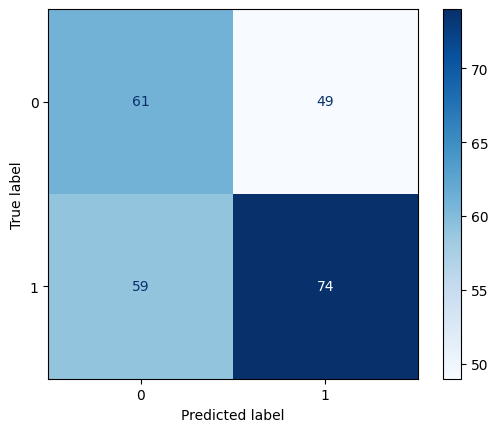

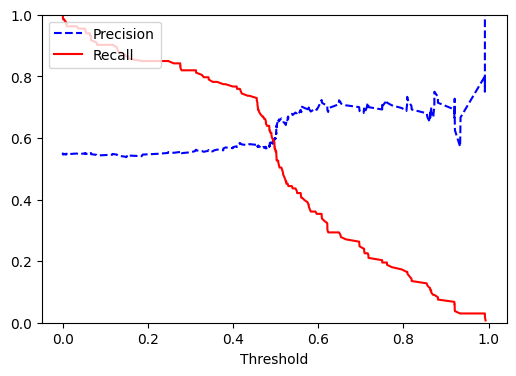

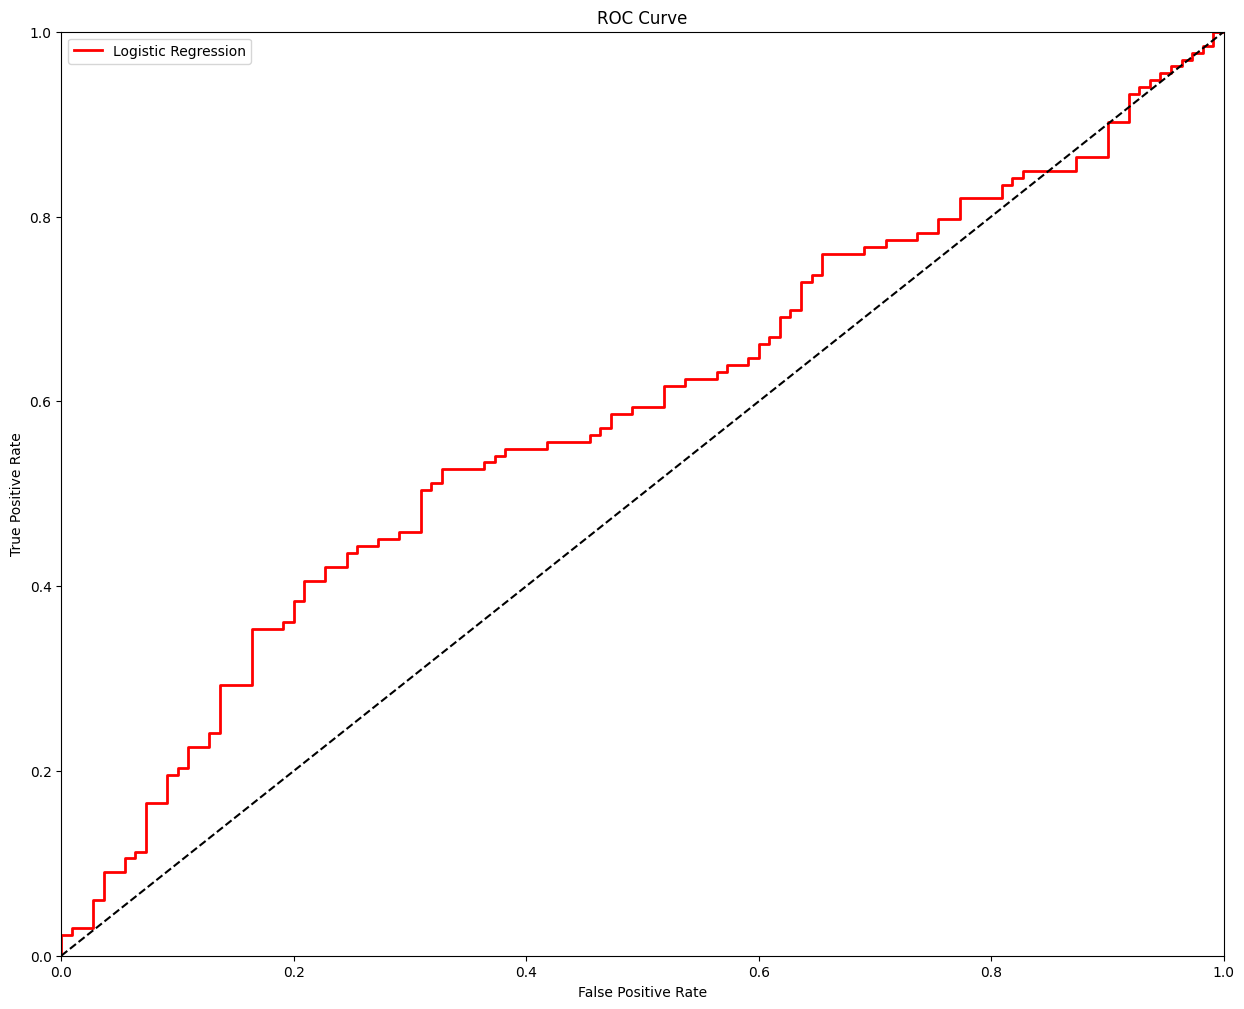

ROC AUC Score: 0.5848


In [23]:
print('Test set accuracy:', np.round(TunedLR.score(X_test,y_test),4))

#Confusion Matrix
y_pred = TunedLR.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')

#Precision, Recall, F1_Score, Specificity
print('Precision Score:', np.round(precision_score(y_test, y_pred),4))
print('Recall Score:', np.round(recall_score(y_test, y_pred),4))
print('F1 Score:', np.round(f1_score(y_test, y_pred),4))
print('Specificity Score:', np.round(recall_score(y_test, y_pred, pos_label=0),4))

#Tradeoff Between Precision and Recall for Every Possible Threshold
plt.figure(figsize=(6, 4))
probabilities_array = TunedLR.predict_proba(X_test)
y_scores = probabilities_array[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#ROC Curve
plt.figure(figsize=(15, 12))
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr_LR, tpr_LR, linewidth=2, color = 'red', label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print('ROC AUC Score:', np.round(roc_auc_score(y_test, y_scores),4))


Test set accuracy: 0.5638
Precision Score: 0.6709
Recall Score: 0.3985
F1 Score: 0.5
Specificity Score: 0.7636


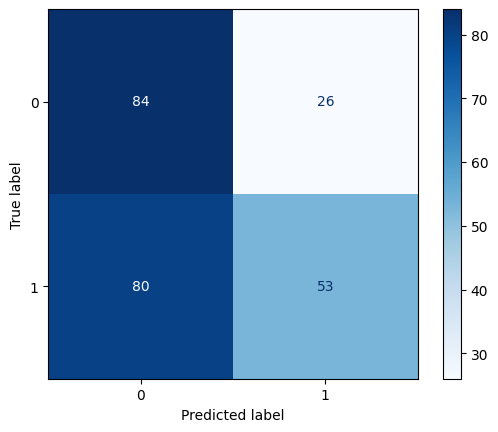

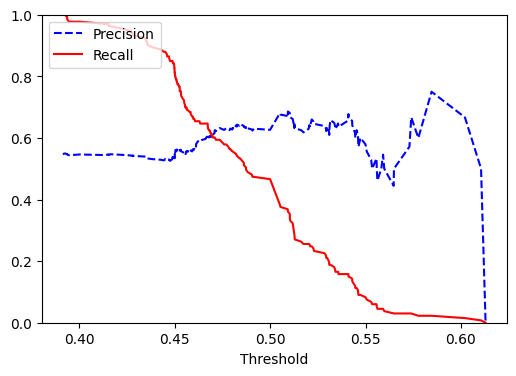

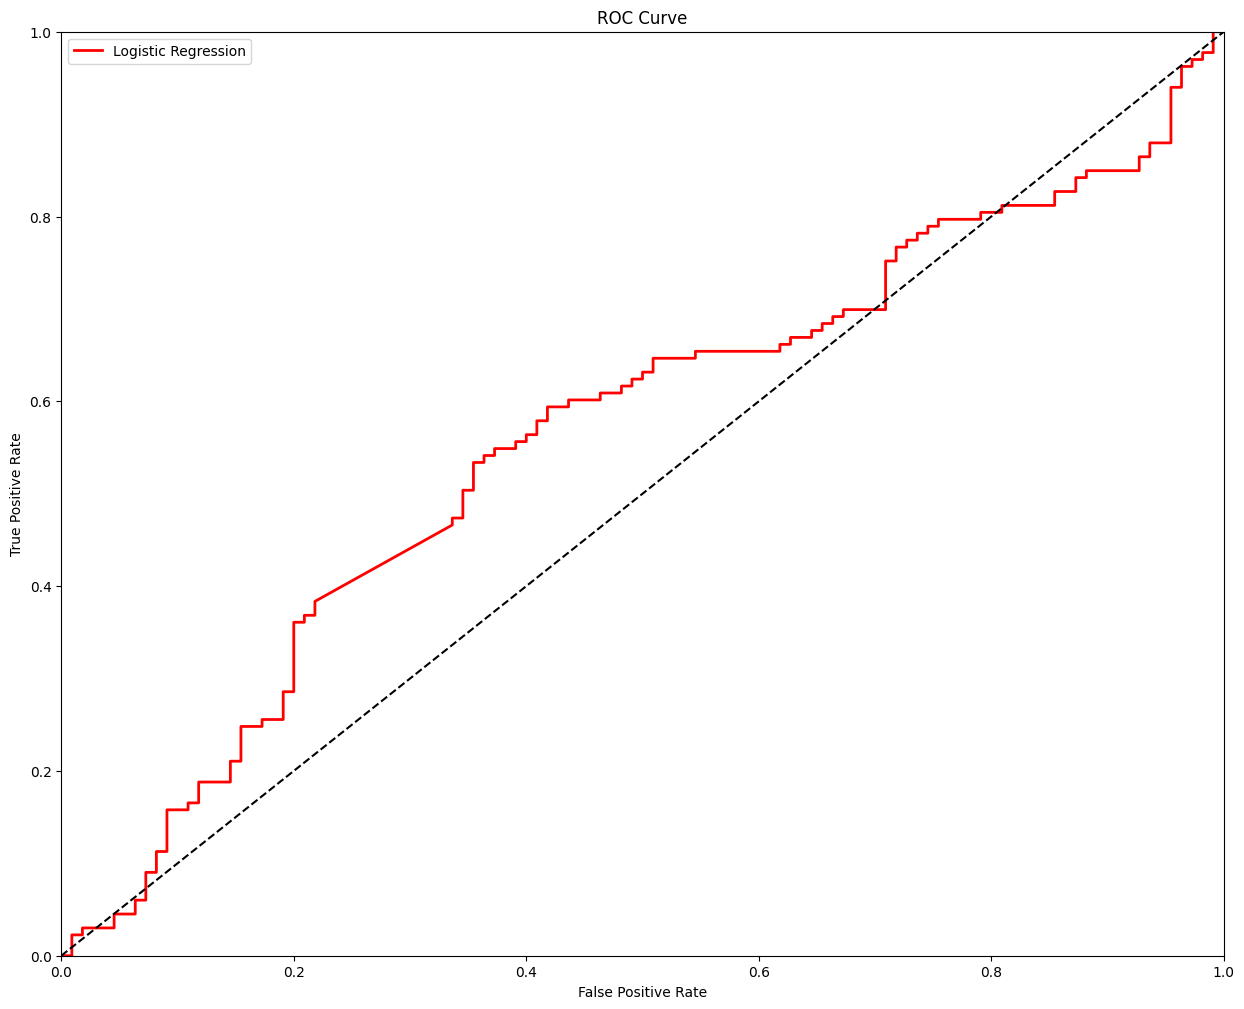

ROC AUC Score: 0.5619


In [24]:
print('Test set accuracy:', np.round(Tuned_SVM.score(X_test,y_test),4))

#Confusion Matrix
y_pred = Tuned_SVM.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')

#Precision, Recall, F1_Score, Specificity
print('Precision Score:', np.round(precision_score(y_test, y_pred),4))
print('Recall Score:', np.round(recall_score(y_test, y_pred),4))
print('F1 Score:', np.round(f1_score(y_test, y_pred),4))
print('Specificity Score:', np.round(recall_score(y_test, y_pred, pos_label=0),4))

#Tradeoff Between Precision and Recall for Every Possible Threshold
plt.figure(figsize=(6, 4))
probabilities_array = Tuned_SVM.predict_proba(X_test)
y_scores = probabilities_array[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#ROC Curve
plt.figure(figsize=(15, 12))
fpr_SVM, tpr_SVM, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr_SVM, tpr_SVM, linewidth=2, color = 'red', label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print('ROC AUC Score:', np.round(roc_auc_score(y_test, y_scores),4))


Test set accuracy: 0.4897
Precision Score: 0.5484
Recall Score: 0.3835
F1 Score: 0.4513
Specificity Score: 0.6182


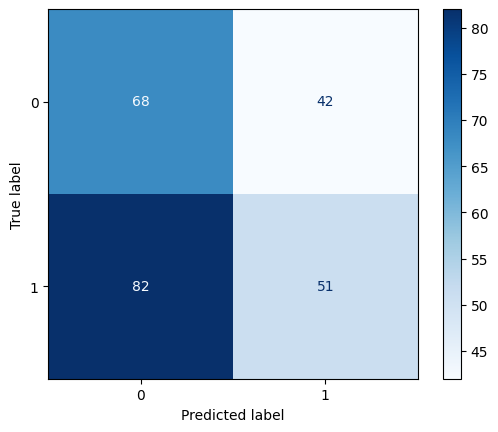

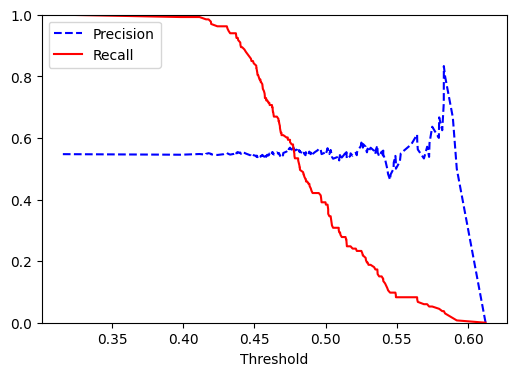

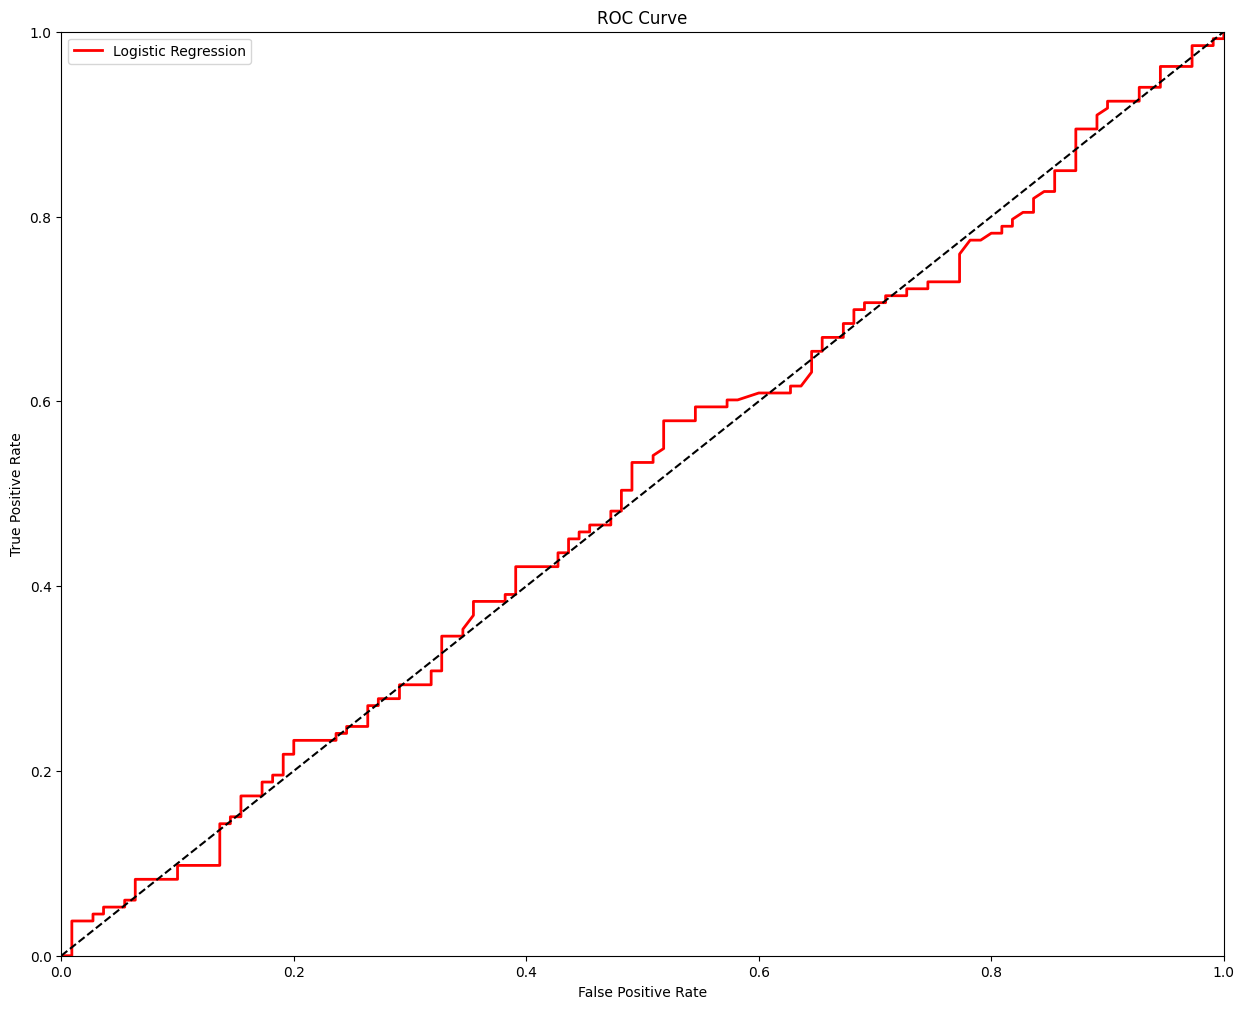

ROC AUC Score: 0.5035


In [25]:
print('Test set accuracy:', np.round(Tuned_RF.score(X_test,y_test),4))

#Confusion Matrix
y_pred = Tuned_RF.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')

#Precision, Recall, F1_Score, Specificity
print('Precision Score:', np.round(precision_score(y_test, y_pred),4))
print('Recall Score:', np.round(recall_score(y_test, y_pred),4))
print('F1 Score:', np.round(f1_score(y_test, y_pred),4))
print('Specificity Score:', np.round(recall_score(y_test, y_pred, pos_label=0),4))

#Tradeoff Between Precision and Recall for Every Possible Threshold
plt.figure(figsize=(6, 4))
probabilities_array = Tuned_RF.predict_proba(X_test)
y_scores = probabilities_array[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#ROC Curve
plt.figure(figsize=(15, 12))
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr_RF, tpr_RF, linewidth=2, color = 'red', label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print('ROC AUC Score:', np.round(roc_auc_score(y_test, y_scores),4))


Test set accuracy: 0.535
Precision Score: 0.5909
Recall Score: 0.4887
F1 Score: 0.535
Specificity Score: 0.5909


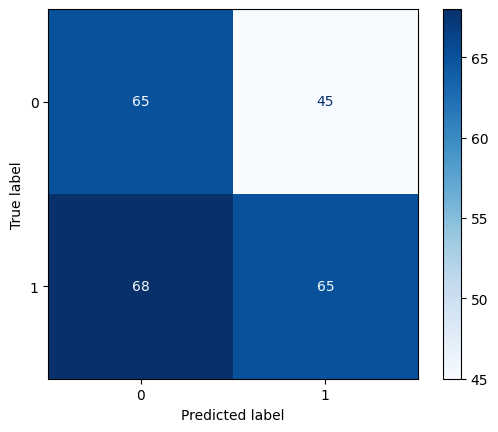

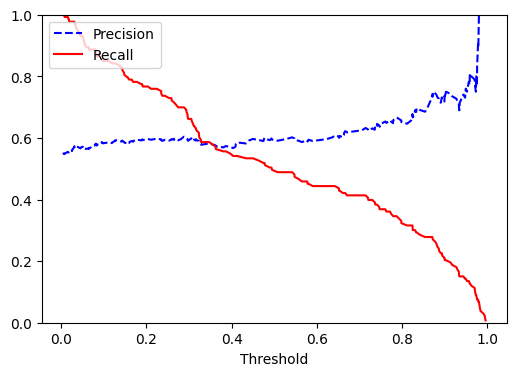

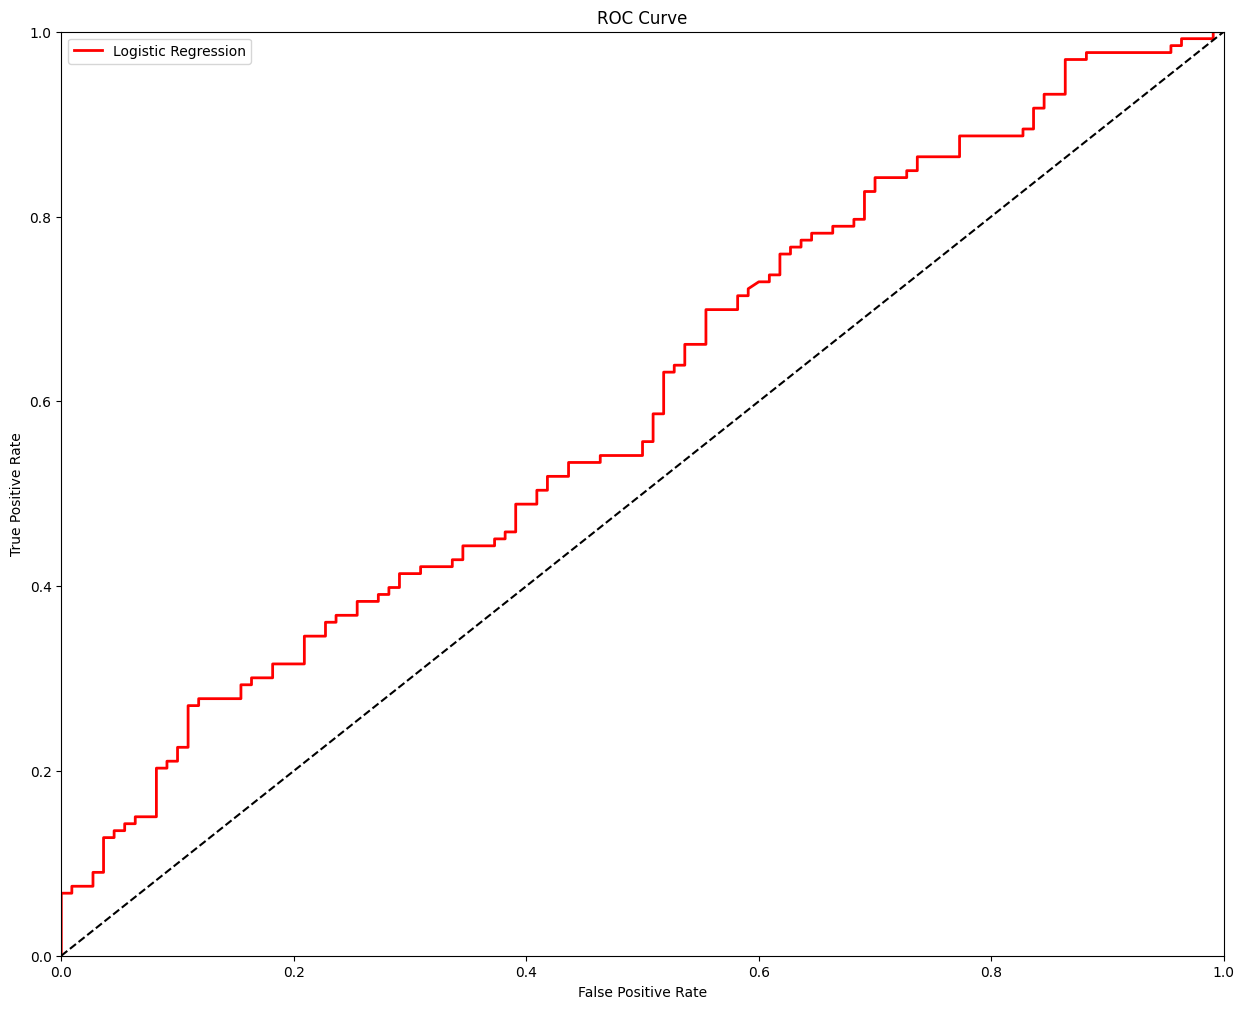

ROC AUC Score: 0.5967


In [26]:
print('Test set accuracy:', np.round(Tuned_XGB.score(X_test,y_test),4))

#Confusion Matrix
y_pred = Tuned_XGB.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')

#Precision, Recall, F1_Score, Specificity
print('Precision Score:', np.round(precision_score(y_test, y_pred),4))
print('Recall Score:', np.round(recall_score(y_test, y_pred),4))
print('F1 Score:', np.round(f1_score(y_test, y_pred),4))
print('Specificity Score:', np.round(recall_score(y_test, y_pred, pos_label=0),4))

#Tradeoff Between Precision and Recall for Every Possible Threshold
plt.figure(figsize=(6, 4))
probabilities_array = Tuned_XGB.predict_proba(X_test)
y_scores = probabilities_array[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#ROC Curve
plt.figure(figsize=(15, 12))
fpr_XGB, tpr_XGB, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr_XGB, tpr_XGB, linewidth=2, color = 'red', label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print('ROC AUC Score:', np.round(roc_auc_score(y_test, y_scores),4))


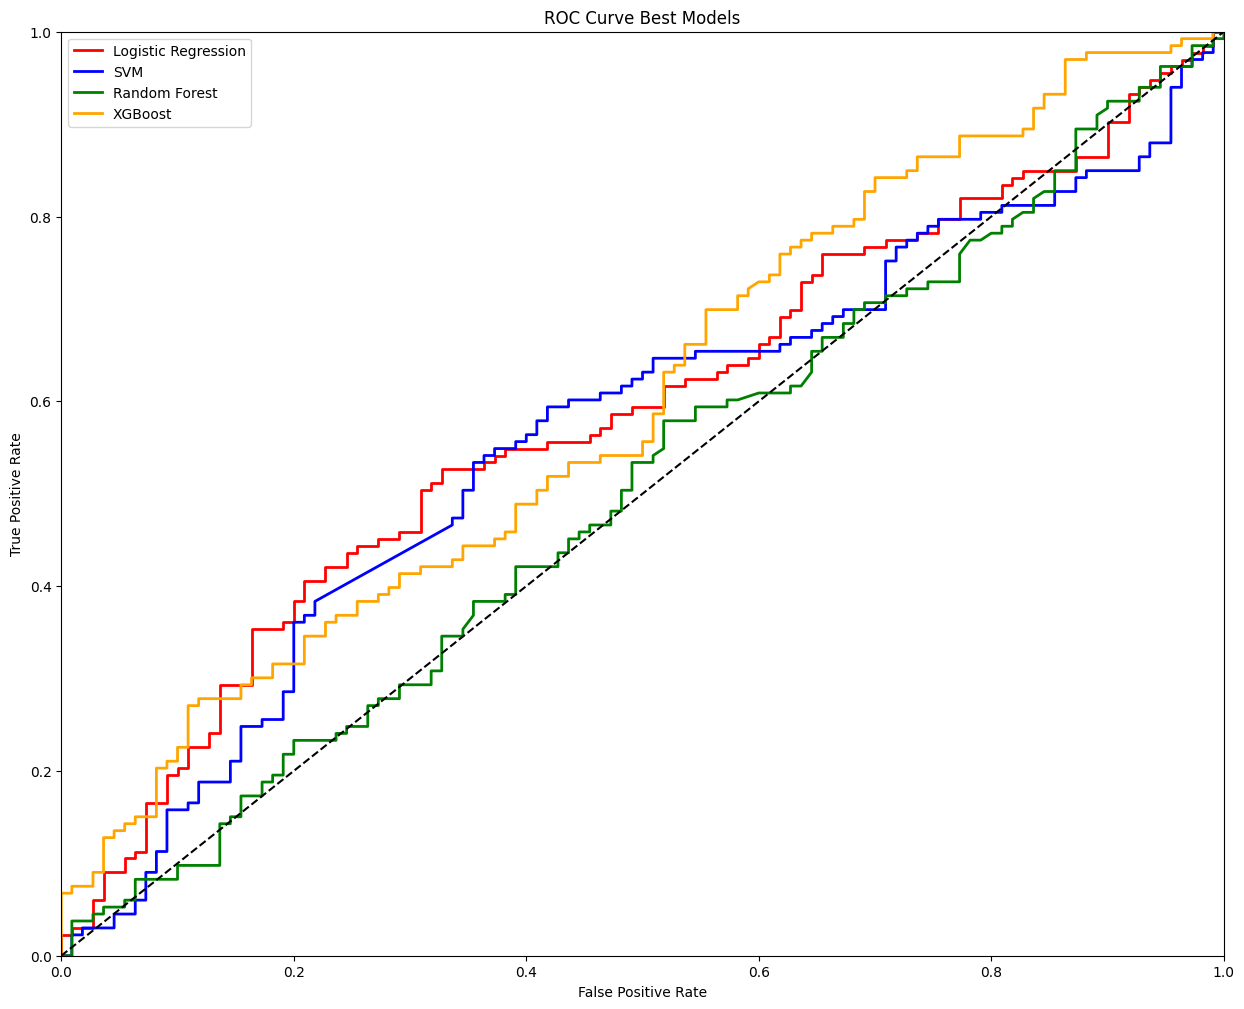

In [27]:
#ROC Curve
plt.figure(figsize=(15, 12))
plt.plot(fpr_LR, tpr_LR, linewidth=2, color = 'red', label='Logistic Regression')
plt.plot(fpr_SVM, tpr_SVM, linewidth=2, color = 'blue', label='SVM')
plt.plot(fpr_RF, tpr_RF, linewidth=2, color = 'green', label='Random Forest')
plt.plot(fpr_XGB, tpr_XGB, linewidth=2, color = 'orange', label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Best Models')
plt.legend()
plt.show()